# Introduction
<hr style="border:2px solid black"> </hr>


**What?** Variational autoencoder on CIFAR-10



# Import modules
<hr style="border:2px solid black"> </hr>

In [2]:
import shutil, os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load dataset
<hr style="border:2px solid black"> </hr>


- In the transforms, we will only convert the data into torch tensors. We will not augment or rotate the data in any way. Either rotating or horizontally flipping the digit images can compromise the orientation information of the data.
- We'll then proceed to donwload the dataset in the path fed to `path`.
- After this, we have to define the train and validation data loaders. We can easily do that using the `DataLoader` module from PyTorch.



In [10]:
# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [11]:
# train and validation data
train_data = datasets.MNIST(
    root='./input/data',
    train=True,
    download=True,
    transform=transform
)
val_data = datasets.MNIST(
    root='./input/data',
    train=False,
    download=True,
    transform=transform
)

0it [00:00, ?it/s]

Extracting ./input/data/MNIST/raw/train-images-idx3-ubyte.gz to ./input/data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./input/data/MNIST/raw/train-labels-idx1-ubyte.gz to ./input/data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./input/data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./input/data/MNIST/raw
Processing...
Done!


In [12]:
batch_size = 64

# training and validation data loaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False
)

# Implementation
<hr style="border:2px solid black"> </hr>


- The `features=16` is used in the output features for the encoder and the input features of the decoder. 
<br><br>
- In the initialisation we have:
    - We have a total of 4 linear layers here.
    - The first two are the encoder layers. The self.enc1 has 784 in_features. This corresponds to the total number of pixels for image in the MNIST dataset (28x28x1). The out_features is 512.
    - Simlarly, we have another encoder layer with 32 output features.
    - The deocoder layers go in reverse order as that of the encoder layers. By this, finally we end up with 784 outputs features in self.dec2.
<br><br>
- In the `reparameterize` function:
    - `mu` is the mean that is coming from encoder’s latent space encoding.
    - `log_var` is the log variance that is coming from the encoder’s latent space.
<br><br>
- In the `forward` we have:
    - Pass the input `x` through the VAE’s encoder layers.
    - Get the latent vector `z` through reparameterization trick using mu and `log_var`.
    - We pass the latent vector `z` through the first decoder layer. Then we get the `reconstruction` of the inputs by giving that output as input to the second decoder layer.



In [2]:
features = 16
# define a simple linear VAE


class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()

        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=features*2)

        # decoder
        self.dec1 = nn.Linear(in_features=features, out_features=512)
        self.dec2 = nn.Linear(in_features=512, out_features=784)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        # standard deviation
        std = torch.exp(0.5*log_var)  
        # `randn_like` as we need the same size. we are creating just a random matrix
        eps = torch.randn_like(std)
        # sampling as if coming from the input space
        sample = mu + (eps * std)  
        return sample

    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = self.enc2(x).view(-1, 2, features)
        
        # get `mu` and `log_var`
        mu = x[:, 0, :]  # the first feature values as mean
        log_var = x[:, 1, :]  # the other feature values as variance
        # get the latent vector through reparameterization trick
        z = self.reparameterize(mu, log_var)

        # decoding
        x = F.relu(self.dec1(z))
        reconstruction = torch.sigmoid(self.dec2(x))
        return reconstruction, mu, log_var

# Model initialisation
<hr style="border:2px solid black"> </hr>


- The loss function here is the Binary Cross Entropy loss. We will use it to calculate the reconstruction loss. Basically, it will calculate the loss between the actual input data points and the reconstructed data points.

- This is only part of the total loss. We will also have to calculate the KL divergence as well.

- We are using reduction='sum' for the BCELoss(). This is specifically done for the case of autoencoders only.



In [18]:
#epochs = args['epochs']
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
model = LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

# The final loss function
<hr style="border:2px solid black"> </hr>

In [23]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# The training function
<hr style="border:2px solid black"> </hr>

In [24]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

# The Validation Function
<hr style="border:2px solid black"> </hr>

In [31]:
os.mkdir("./outputs")
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, _ = data
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(val_data)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction.view(batch_size, 1, 28, 28)[:8]))
                save_image(both.cpu(), f"./outputs/output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

# Start the training
<hr style="border:2px solid black"> </hr>

In [36]:
train_loss = []
val_loss = []
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")









  0%|          | 0/937 [00:00<?, ?it/s]







  1%|          | 5/937 [00:00<00:18, 49.46it/s]

Epoch 1 of 20










  1%|          | 10/937 [00:00<00:19, 48.59it/s]







  2%|▏         | 16/937 [00:00<00:18, 50.89it/s]







  2%|▏         | 22/937 [00:00<00:17, 52.30it/s]







  3%|▎         | 28/937 [00:00<00:16, 53.68it/s]







  4%|▎         | 34/937 [00:00<00:16, 54.29it/s]







  4%|▍         | 40/937 [00:00<00:16, 54.76it/s]







  5%|▍         | 46/937 [00:00<00:16, 54.74it/s]







  6%|▌         | 52/937 [00:00<00:16, 54.83it/s]







  6%|▌         | 58/937 [00:01<00:16, 54.83it/s]







  7%|▋         | 64/937 [00:01<00:16, 53.91it/s]







  7%|▋         | 70/937 [00:01<00:16, 51.90it/s]







  8%|▊         | 76/937 [00:01<00:16, 52.33it/s]







  9%|▉         | 82/937 [00:01<00:16, 53.17it/s]







  9%|▉         | 88/937 [00:01<00:15, 53.95it/s]







 10%|█         | 94/937 [00:01<00:15, 53.84it/s]







 11%|█         | 100/937 [00:01<00:15, 54.00it/s]







 11%|█▏        | 106/937 [00:01<00:15, 54.55it/s]







 12%|█▏        | 112/937 [00:02<00:15,

Train Loss: 111.3570
Val Loss: 110.3058
Epoch 2 of 20










  1%|▏         | 12/937 [00:00<00:16, 56.23it/s]







  2%|▏         | 18/937 [00:00<00:16, 55.99it/s]







  3%|▎         | 24/937 [00:00<00:16, 55.91it/s]







  3%|▎         | 30/937 [00:00<00:16, 55.49it/s]







  4%|▍         | 36/937 [00:00<00:16, 55.21it/s]







  4%|▍         | 42/937 [00:00<00:16, 55.28it/s]







  5%|▌         | 48/937 [00:00<00:16, 55.40it/s]







  6%|▌         | 54/937 [00:00<00:15, 55.58it/s]







  6%|▋         | 60/937 [00:01<00:16, 52.84it/s]







  7%|▋         | 66/937 [00:01<00:16, 53.78it/s]







  8%|▊         | 72/937 [00:01<00:15, 54.13it/s]







  8%|▊         | 78/937 [00:01<00:15, 54.07it/s]







  9%|▉         | 84/937 [00:01<00:15, 54.45it/s]







 10%|▉         | 90/937 [00:01<00:15, 54.41it/s]







 10%|█         | 96/937 [00:01<00:15, 54.50it/s]







 11%|█         | 102/937 [00:01<00:15, 54.75it/s]







 12%|█▏        | 108/937 [00:01<00:15, 55.08it/s]







 12%|█▏        | 114/937 [00:02<00:14,

Train Loss: 110.7724
Val Loss: 109.8458
Epoch 3 of 20










  1%|▏         | 12/937 [00:00<00:17, 53.28it/s]







  2%|▏         | 18/937 [00:00<00:17, 52.58it/s]







  3%|▎         | 24/937 [00:00<00:16, 53.81it/s]







  3%|▎         | 30/937 [00:00<00:16, 54.54it/s]







  4%|▍         | 36/937 [00:00<00:16, 54.91it/s]







  4%|▍         | 42/937 [00:00<00:16, 55.12it/s]







  5%|▌         | 48/937 [00:00<00:16, 55.01it/s]







  6%|▌         | 54/937 [00:00<00:16, 54.81it/s]







  6%|▋         | 60/937 [00:01<00:15, 55.49it/s]







  7%|▋         | 66/937 [00:01<00:15, 56.02it/s]







  8%|▊         | 72/937 [00:01<00:15, 56.37it/s]







  8%|▊         | 78/937 [00:01<00:15, 56.53it/s]







  9%|▉         | 84/937 [00:01<00:15, 56.73it/s]







 10%|▉         | 90/937 [00:01<00:14, 56.73it/s]







 10%|█         | 96/937 [00:01<00:14, 56.84it/s]







 11%|█         | 102/937 [00:01<00:14, 57.04it/s]







 12%|█▏        | 108/937 [00:01<00:14, 56.96it/s]







 12%|█▏        | 114/937 [00:02<00:14,

Train Loss: 110.2965
Val Loss: 109.3080
Epoch 4 of 20










  1%|▏         | 12/937 [00:00<00:16, 55.39it/s]







  2%|▏         | 18/937 [00:00<00:16, 55.78it/s]







  3%|▎         | 24/937 [00:00<00:16, 56.18it/s]







  3%|▎         | 30/937 [00:00<00:16, 56.43it/s]







  4%|▍         | 36/937 [00:00<00:16, 55.75it/s]







  4%|▍         | 42/937 [00:00<00:15, 55.96it/s]







  5%|▌         | 48/937 [00:00<00:15, 55.95it/s]







  6%|▌         | 54/937 [00:00<00:15, 56.09it/s]







  6%|▋         | 60/937 [00:01<00:15, 56.27it/s]







  7%|▋         | 66/937 [00:01<00:15, 55.96it/s]







  8%|▊         | 72/937 [00:01<00:15, 55.89it/s]







  8%|▊         | 78/937 [00:01<00:15, 55.89it/s]







  9%|▉         | 84/937 [00:01<00:15, 55.86it/s]







 10%|▉         | 90/937 [00:01<00:15, 55.80it/s]







 10%|█         | 96/937 [00:01<00:14, 56.16it/s]







 11%|█         | 102/937 [00:01<00:14, 56.34it/s]







 12%|█▏        | 108/937 [00:01<00:14, 56.34it/s]







 12%|█▏        | 114/937 [00:02<00:14,

Train Loss: 109.8404
Val Loss: 108.9380
Epoch 5 of 20










  1%|▏         | 12/937 [00:00<00:17, 54.11it/s]







  2%|▏         | 18/937 [00:00<00:16, 54.29it/s]







  3%|▎         | 24/937 [00:00<00:16, 54.71it/s]







  3%|▎         | 30/937 [00:00<00:16, 54.84it/s]







  4%|▍         | 36/937 [00:00<00:16, 55.57it/s]







  4%|▍         | 42/937 [00:00<00:15, 56.06it/s]







  5%|▌         | 48/937 [00:00<00:15, 55.59it/s]







  6%|▌         | 54/937 [00:00<00:15, 56.05it/s]







  6%|▋         | 60/937 [00:01<00:15, 55.88it/s]







  7%|▋         | 66/937 [00:01<00:15, 56.01it/s]







  8%|▊         | 72/937 [00:01<00:15, 56.22it/s]







  8%|▊         | 78/937 [00:01<00:15, 56.31it/s]







  9%|▉         | 84/937 [00:01<00:15, 56.55it/s]







 10%|▉         | 90/937 [00:01<00:15, 56.11it/s]







 10%|█         | 96/937 [00:01<00:14, 56.31it/s]







 11%|█         | 102/937 [00:01<00:14, 56.05it/s]







 12%|█▏        | 108/937 [00:01<00:14, 56.28it/s]







 12%|█▏        | 114/937 [00:02<00:14,

Train Loss: 109.4591
Val Loss: 108.5661
Epoch 6 of 20










  1%|▏         | 12/937 [00:00<00:16, 55.21it/s]







  2%|▏         | 18/937 [00:00<00:16, 56.19it/s]







  3%|▎         | 24/937 [00:00<00:16, 55.64it/s]







  3%|▎         | 30/937 [00:00<00:16, 55.71it/s]







  4%|▍         | 36/937 [00:00<00:16, 55.70it/s]







  4%|▍         | 42/937 [00:00<00:16, 55.28it/s]







  5%|▌         | 48/937 [00:00<00:16, 55.52it/s]







  6%|▌         | 54/937 [00:00<00:15, 55.93it/s]







  6%|▋         | 60/937 [00:01<00:15, 56.14it/s]







  7%|▋         | 66/937 [00:01<00:15, 56.13it/s]







  8%|▊         | 72/937 [00:01<00:15, 55.30it/s]







  8%|▊         | 78/937 [00:01<00:15, 54.90it/s]







  9%|▉         | 84/937 [00:01<00:15, 55.08it/s]







 10%|▉         | 90/937 [00:01<00:15, 55.76it/s]







 10%|█         | 96/937 [00:01<00:15, 55.86it/s]







 11%|█         | 102/937 [00:01<00:15, 55.43it/s]







 12%|█▏        | 108/937 [00:01<00:14, 55.44it/s]







 12%|█▏        | 114/937 [00:02<00:14,

Train Loss: 109.0900
Val Loss: 108.3692
Epoch 7 of 20










  1%|▏         | 12/937 [00:00<00:15, 57.85it/s]







  2%|▏         | 18/937 [00:00<00:15, 58.17it/s]







  3%|▎         | 24/937 [00:00<00:15, 58.24it/s]







  3%|▎         | 30/937 [00:00<00:15, 58.33it/s]







  4%|▍         | 36/937 [00:00<00:15, 58.03it/s]







  4%|▍         | 42/937 [00:00<00:15, 57.93it/s]







  5%|▌         | 48/937 [00:00<00:15, 57.99it/s]







  6%|▌         | 54/937 [00:00<00:15, 57.99it/s]







  6%|▋         | 60/937 [00:01<00:15, 58.21it/s]







  7%|▋         | 66/937 [00:01<00:14, 58.28it/s]







  8%|▊         | 72/937 [00:01<00:14, 57.83it/s]







  8%|▊         | 78/937 [00:01<00:14, 58.04it/s]







  9%|▉         | 84/937 [00:01<00:14, 58.11it/s]







 10%|▉         | 90/937 [00:01<00:14, 58.36it/s]







 10%|█         | 96/937 [00:01<00:14, 58.12it/s]







 11%|█         | 102/937 [00:01<00:14, 58.21it/s]







 12%|█▏        | 108/937 [00:01<00:14, 57.98it/s]







 12%|█▏        | 114/937 [00:01<00:14,

Train Loss: 108.7791
Val Loss: 108.0040
Epoch 8 of 20










  1%|▏         | 12/937 [00:00<00:17, 52.65it/s]







  2%|▏         | 18/937 [00:00<00:16, 54.32it/s]







  3%|▎         | 24/937 [00:00<00:16, 55.18it/s]







  3%|▎         | 30/937 [00:00<00:16, 54.94it/s]







  4%|▍         | 36/937 [00:00<00:16, 55.41it/s]







  4%|▍         | 42/937 [00:00<00:16, 55.02it/s]







  5%|▌         | 48/937 [00:00<00:15, 55.83it/s]







  6%|▌         | 54/937 [00:00<00:15, 56.10it/s]







  6%|▋         | 60/937 [00:01<00:15, 55.96it/s]







  7%|▋         | 66/937 [00:01<00:15, 56.02it/s]







  8%|▊         | 72/937 [00:01<00:15, 55.74it/s]







  8%|▊         | 78/937 [00:01<00:15, 56.11it/s]







  9%|▉         | 84/937 [00:01<00:15, 56.09it/s]







 10%|▉         | 90/937 [00:01<00:15, 56.35it/s]







 10%|█         | 96/937 [00:01<00:14, 56.45it/s]







 11%|█         | 102/937 [00:01<00:14, 56.04it/s]







 12%|█▏        | 108/937 [00:01<00:14, 56.20it/s]







 12%|█▏        | 114/937 [00:02<00:14,

Train Loss: 108.4807
Val Loss: 107.8193
Epoch 9 of 20










  1%|▏         | 12/937 [00:00<00:17, 52.81it/s]







  2%|▏         | 18/937 [00:00<00:16, 54.42it/s]







  3%|▎         | 24/937 [00:00<00:16, 54.63it/s]







  3%|▎         | 30/937 [00:00<00:16, 55.06it/s]







  4%|▍         | 36/937 [00:00<00:16, 55.36it/s]







  4%|▍         | 42/937 [00:00<00:15, 55.94it/s]







  5%|▌         | 48/937 [00:00<00:15, 56.07it/s]







  6%|▌         | 54/937 [00:00<00:15, 56.22it/s]







  6%|▋         | 60/937 [00:01<00:15, 56.43it/s]







  7%|▋         | 66/937 [00:01<00:15, 55.74it/s]







  8%|▊         | 72/937 [00:01<00:15, 55.76it/s]







  8%|▊         | 78/937 [00:01<00:15, 55.01it/s]







  9%|▉         | 84/937 [00:01<00:15, 55.48it/s]







 10%|▉         | 90/937 [00:01<00:15, 55.48it/s]







 10%|█         | 96/937 [00:01<00:15, 55.48it/s]







 11%|█         | 102/937 [00:01<00:14, 55.68it/s]







 12%|█▏        | 108/937 [00:01<00:14, 55.81it/s]







 12%|█▏        | 114/937 [00:02<00:14,

Train Loss: 108.2315
Val Loss: 107.5466
Epoch 10 of 20










  1%|▏         | 12/937 [00:00<00:16, 54.69it/s]







  2%|▏         | 18/937 [00:00<00:16, 54.48it/s]







  3%|▎         | 24/937 [00:00<00:16, 54.91it/s]







  3%|▎         | 30/937 [00:00<00:16, 54.77it/s]







  4%|▍         | 36/937 [00:00<00:16, 54.13it/s]







  4%|▍         | 42/937 [00:00<00:16, 54.54it/s]







  5%|▌         | 48/937 [00:00<00:16, 54.20it/s]







  6%|▌         | 54/937 [00:00<00:16, 54.11it/s]







  6%|▋         | 60/937 [00:01<00:16, 54.38it/s]







  7%|▋         | 66/937 [00:01<00:15, 54.48it/s]







  8%|▊         | 72/937 [00:01<00:15, 54.83it/s]







  8%|▊         | 78/937 [00:01<00:15, 54.60it/s]







  9%|▉         | 84/937 [00:01<00:15, 54.84it/s]







 10%|▉         | 90/937 [00:01<00:15, 54.33it/s]







 10%|█         | 96/937 [00:01<00:15, 54.68it/s]







 11%|█         | 102/937 [00:01<00:15, 54.86it/s]







 12%|█▏        | 108/937 [00:01<00:15, 54.70it/s]







 12%|█▏        | 114/937 [00:02<00:15,

Train Loss: 107.9532
Val Loss: 107.1821
Epoch 11 of 20










  1%|▏         | 12/937 [00:00<00:17, 53.74it/s]







  2%|▏         | 18/937 [00:00<00:16, 54.62it/s]







  3%|▎         | 24/937 [00:00<00:16, 55.03it/s]







  3%|▎         | 30/937 [00:00<00:16, 55.84it/s]







  4%|▍         | 36/937 [00:00<00:16, 56.22it/s]







  4%|▍         | 42/937 [00:00<00:16, 55.57it/s]







  5%|▌         | 48/937 [00:00<00:16, 54.63it/s]







  6%|▌         | 54/937 [00:00<00:16, 54.21it/s]







  6%|▋         | 60/937 [00:01<00:16, 54.33it/s]







  7%|▋         | 66/937 [00:01<00:15, 54.84it/s]







  8%|▊         | 72/937 [00:01<00:15, 55.31it/s]







  8%|▊         | 78/937 [00:01<00:15, 55.52it/s]







  9%|▉         | 84/937 [00:01<00:15, 55.52it/s]







 10%|▉         | 90/937 [00:01<00:15, 55.46it/s]







 10%|█         | 96/937 [00:01<00:15, 55.43it/s]







 11%|█         | 102/937 [00:01<00:14, 55.87it/s]







 12%|█▏        | 108/937 [00:01<00:14, 56.17it/s]







 12%|█▏        | 114/937 [00:02<00:14,

Train Loss: 107.7128
Val Loss: 107.0389
Epoch 12 of 20










  1%|▏         | 12/937 [00:00<00:16, 55.96it/s]







  2%|▏         | 18/937 [00:00<00:16, 54.89it/s]







  3%|▎         | 24/937 [00:00<00:16, 55.51it/s]







  3%|▎         | 30/937 [00:00<00:17, 52.84it/s]







  4%|▍         | 36/937 [00:00<00:17, 52.93it/s]







  4%|▍         | 42/937 [00:00<00:17, 51.75it/s]







  5%|▌         | 48/937 [00:00<00:16, 52.54it/s]







  6%|▌         | 54/937 [00:01<00:16, 53.46it/s]







  6%|▋         | 60/937 [00:01<00:16, 54.56it/s]







  7%|▋         | 66/937 [00:01<00:15, 55.60it/s]







  8%|▊         | 72/937 [00:01<00:15, 55.01it/s]







  8%|▊         | 78/937 [00:01<00:15, 55.36it/s]







  9%|▉         | 84/937 [00:01<00:15, 55.87it/s]







 10%|▉         | 90/937 [00:01<00:15, 56.33it/s]







 10%|█         | 96/937 [00:01<00:14, 56.96it/s]







 11%|█         | 102/937 [00:01<00:14, 57.21it/s]







 12%|█▏        | 108/937 [00:01<00:14, 57.55it/s]







 12%|█▏        | 114/937 [00:02<00:14,

Train Loss: 107.4970
Val Loss: 106.9030
Epoch 13 of 20










  1%|▏         | 12/937 [00:00<00:16, 55.41it/s]







  2%|▏         | 18/937 [00:00<00:16, 55.22it/s]







  3%|▎         | 24/937 [00:00<00:16, 55.67it/s]







  3%|▎         | 30/937 [00:00<00:16, 55.43it/s]







  4%|▍         | 36/937 [00:00<00:16, 55.41it/s]







  4%|▍         | 42/937 [00:00<00:16, 55.73it/s]







  5%|▌         | 48/937 [00:00<00:16, 55.14it/s]







  6%|▌         | 54/937 [00:00<00:16, 54.68it/s]







  6%|▋         | 60/937 [00:01<00:15, 55.40it/s]







  7%|▋         | 66/937 [00:01<00:15, 55.63it/s]







  8%|▊         | 72/937 [00:01<00:15, 54.97it/s]







  8%|▊         | 78/937 [00:01<00:15, 54.96it/s]







  9%|▉         | 84/937 [00:01<00:15, 55.33it/s]







 10%|▉         | 90/937 [00:01<00:15, 55.72it/s]







 10%|█         | 96/937 [00:01<00:14, 56.07it/s]







 11%|█         | 102/937 [00:01<00:14, 56.36it/s]







 12%|█▏        | 108/937 [00:01<00:14, 56.05it/s]







 12%|█▏        | 114/937 [00:02<00:14,

Train Loss: 107.2652
Val Loss: 106.5923
Epoch 14 of 20










  1%|▏         | 12/937 [00:00<00:17, 53.27it/s]







  2%|▏         | 18/937 [00:00<00:17, 53.52it/s]







  3%|▎         | 24/937 [00:00<00:16, 53.78it/s]







  3%|▎         | 30/937 [00:00<00:16, 53.93it/s]







  4%|▍         | 36/937 [00:00<00:16, 53.96it/s]







  4%|▍         | 42/937 [00:00<00:16, 54.45it/s]







  5%|▌         | 48/937 [00:00<00:16, 55.00it/s]







  6%|▌         | 54/937 [00:00<00:15, 55.54it/s]







  6%|▋         | 60/937 [00:01<00:15, 56.03it/s]







  7%|▋         | 66/937 [00:01<00:15, 56.31it/s]







  8%|▊         | 72/937 [00:01<00:15, 56.24it/s]







  8%|▊         | 78/937 [00:01<00:15, 56.62it/s]







  9%|▉         | 84/937 [00:01<00:15, 56.70it/s]







 10%|▉         | 90/937 [00:01<00:14, 56.88it/s]







 10%|█         | 96/937 [00:01<00:14, 56.78it/s]







 11%|█         | 102/937 [00:01<00:14, 56.92it/s]







 12%|█▏        | 108/937 [00:01<00:14, 56.77it/s]







 12%|█▏        | 114/937 [00:02<00:14,

Train Loss: 107.1035
Val Loss: 106.5794
Epoch 15 of 20










  1%|▏         | 12/937 [00:00<00:16, 55.80it/s]







  2%|▏         | 18/937 [00:00<00:16, 55.87it/s]







  3%|▎         | 24/937 [00:00<00:16, 55.63it/s]







  3%|▎         | 30/937 [00:00<00:16, 56.35it/s]







  4%|▍         | 36/937 [00:00<00:15, 56.36it/s]







  4%|▍         | 42/937 [00:00<00:15, 56.82it/s]







  5%|▌         | 48/937 [00:00<00:15, 57.09it/s]







  6%|▌         | 54/937 [00:00<00:15, 56.98it/s]







  6%|▋         | 60/937 [00:01<00:15, 56.71it/s]







  7%|▋         | 66/937 [00:01<00:15, 57.01it/s]







  8%|▊         | 72/937 [00:01<00:15, 56.93it/s]







  8%|▊         | 78/937 [00:01<00:15, 56.54it/s]







  9%|▉         | 84/937 [00:01<00:14, 57.00it/s]







 10%|▉         | 90/937 [00:01<00:14, 57.16it/s]







 10%|█         | 96/937 [00:01<00:14, 57.20it/s]







 11%|█         | 102/937 [00:01<00:14, 57.26it/s]







 12%|█▏        | 108/937 [00:01<00:14, 57.04it/s]







 12%|█▏        | 114/937 [00:02<00:14,

Train Loss: 106.9089
Val Loss: 106.4083
Epoch 16 of 20










  1%|▏         | 12/937 [00:00<00:17, 52.46it/s]







  2%|▏         | 18/937 [00:00<00:16, 54.22it/s]







  3%|▎         | 24/937 [00:00<00:16, 55.44it/s]







  3%|▎         | 30/937 [00:00<00:16, 54.51it/s]







  4%|▍         | 36/937 [00:00<00:16, 53.78it/s]







  4%|▍         | 42/937 [00:00<00:16, 54.49it/s]







  5%|▌         | 48/937 [00:00<00:16, 55.43it/s]







  6%|▌         | 54/937 [00:00<00:15, 56.13it/s]







  6%|▋         | 60/937 [00:01<00:15, 56.66it/s]







  7%|▋         | 66/937 [00:01<00:15, 55.64it/s]







  8%|▊         | 72/937 [00:01<00:15, 55.34it/s]







  8%|▊         | 78/937 [00:01<00:15, 55.41it/s]







  9%|▉         | 84/937 [00:01<00:15, 56.01it/s]







 10%|▉         | 90/937 [00:01<00:15, 56.34it/s]







 10%|█         | 96/937 [00:01<00:14, 56.50it/s]







 11%|█         | 102/937 [00:01<00:14, 56.89it/s]







 12%|█▏        | 108/937 [00:01<00:14, 57.14it/s]







 12%|█▏        | 114/937 [00:02<00:14,

Train Loss: 106.7411
Val Loss: 106.2095
Epoch 17 of 20










  1%|▏         | 12/937 [00:00<00:16, 55.99it/s]







  2%|▏         | 18/937 [00:00<00:17, 53.99it/s]







  3%|▎         | 24/937 [00:00<00:16, 54.58it/s]







  3%|▎         | 30/937 [00:00<00:16, 55.65it/s]







  4%|▍         | 36/937 [00:00<00:16, 54.58it/s]







  4%|▍         | 42/937 [00:00<00:16, 54.47it/s]







  5%|▌         | 48/937 [00:00<00:16, 54.96it/s]







  6%|▌         | 54/937 [00:00<00:15, 55.43it/s]







  6%|▋         | 60/937 [00:01<00:15, 55.22it/s]







  7%|▋         | 66/937 [00:01<00:15, 54.57it/s]







  8%|▊         | 72/937 [00:01<00:15, 54.56it/s]







  8%|▊         | 78/937 [00:01<00:15, 54.37it/s]







  9%|▉         | 84/937 [00:01<00:15, 54.23it/s]







 10%|▉         | 90/937 [00:01<00:15, 54.97it/s]







 10%|█         | 96/937 [00:01<00:15, 54.15it/s]







 11%|█         | 102/937 [00:01<00:15, 54.10it/s]







 12%|█▏        | 108/937 [00:01<00:15, 54.37it/s]







 12%|█▏        | 114/937 [00:02<00:15,

Train Loss: 106.6069
Val Loss: 106.1323
Epoch 18 of 20










  1%|▏         | 12/937 [00:00<00:15, 58.16it/s]







  2%|▏         | 18/937 [00:00<00:15, 58.14it/s]







  3%|▎         | 24/937 [00:00<00:15, 57.71it/s]







  3%|▎         | 30/937 [00:00<00:15, 57.75it/s]







  4%|▍         | 36/937 [00:00<00:15, 57.83it/s]







  4%|▍         | 42/937 [00:00<00:15, 57.92it/s]







  5%|▌         | 48/937 [00:00<00:15, 56.15it/s]







  6%|▌         | 54/937 [00:00<00:16, 54.72it/s]







  6%|▋         | 60/937 [00:01<00:16, 54.70it/s]







  7%|▋         | 66/937 [00:01<00:15, 55.35it/s]







  8%|▊         | 72/937 [00:01<00:15, 55.88it/s]







  8%|▊         | 78/937 [00:01<00:15, 55.93it/s]







  9%|▉         | 84/937 [00:01<00:15, 56.28it/s]







 10%|▉         | 90/937 [00:01<00:15, 55.76it/s]







 10%|█         | 96/937 [00:01<00:14, 56.28it/s]







 11%|█         | 102/937 [00:01<00:14, 56.58it/s]







 12%|█▏        | 108/937 [00:01<00:14, 56.14it/s]







 12%|█▏        | 114/937 [00:02<00:15,

Train Loss: 106.4629
Val Loss: 105.9621
Epoch 19 of 20










  1%|▏         | 12/937 [00:00<00:18, 50.43it/s]







  2%|▏         | 18/937 [00:00<00:17, 52.86it/s]







  3%|▎         | 24/937 [00:00<00:16, 54.31it/s]







  3%|▎         | 30/937 [00:00<00:16, 55.62it/s]







  4%|▍         | 36/937 [00:00<00:16, 56.25it/s]







  4%|▍         | 42/937 [00:00<00:15, 56.86it/s]







  5%|▌         | 48/937 [00:00<00:15, 57.46it/s]







  6%|▌         | 54/937 [00:00<00:15, 57.64it/s]







  6%|▋         | 60/937 [00:01<00:15, 57.81it/s]







  7%|▋         | 66/937 [00:01<00:15, 58.02it/s]







  8%|▊         | 72/937 [00:01<00:14, 57.86it/s]







  8%|▊         | 78/937 [00:01<00:14, 57.66it/s]







  9%|▉         | 84/937 [00:01<00:14, 57.85it/s]







 10%|▉         | 90/937 [00:01<00:14, 57.87it/s]







 10%|█         | 96/937 [00:01<00:14, 57.91it/s]







 11%|█         | 102/937 [00:01<00:14, 58.02it/s]







 12%|█▏        | 108/937 [00:01<00:14, 58.08it/s]







 12%|█▏        | 114/937 [00:01<00:14,

Train Loss: 106.2920
Val Loss: 105.8795
Epoch 20 of 20










  1%|▏         | 12/937 [00:00<00:16, 56.23it/s]







  2%|▏         | 18/937 [00:00<00:16, 56.70it/s]







  3%|▎         | 24/937 [00:00<00:16, 57.01it/s]







  3%|▎         | 30/937 [00:00<00:15, 57.21it/s]







  4%|▍         | 36/937 [00:00<00:16, 55.85it/s]







  4%|▍         | 42/937 [00:00<00:16, 55.74it/s]







  5%|▌         | 48/937 [00:00<00:15, 55.67it/s]







  6%|▌         | 54/937 [00:00<00:15, 55.93it/s]







  6%|▋         | 60/937 [00:01<00:15, 56.06it/s]







  7%|▋         | 66/937 [00:01<00:15, 56.27it/s]







  8%|▊         | 72/937 [00:01<00:15, 56.27it/s]







  8%|▊         | 78/937 [00:01<00:15, 56.08it/s]







  9%|▉         | 84/937 [00:01<00:15, 55.15it/s]







 10%|▉         | 90/937 [00:01<00:15, 55.47it/s]







 10%|█         | 96/937 [00:01<00:15, 55.48it/s]







 11%|█         | 102/937 [00:01<00:15, 55.41it/s]







 12%|█▏        | 108/937 [00:01<00:14, 55.59it/s]







 12%|█▏        | 114/937 [00:02<00:14,

Train Loss: 106.1735
Val Loss: 105.7575


# Post-processing
<hr style="border:2px solid black"> </hr>


- The reconstructions from the first epoches are a bit blurry. 
- In particular, in the first epoch you can see how rhe VAE model has reconstructed the digit 8 as 9 in all cases and 4 as 0. **Why?** This is expected as VAE tries to reconstruct the original images from a continuous vector space. So, most probably it will generate an image closer to something else when it is not very sure.
- After the first epoch the reconstructin improves as it can be clearly seen from the series of pictures below.
- Probably, there is still space for improvement. Training for longer would improve the results shown in the last epoch.



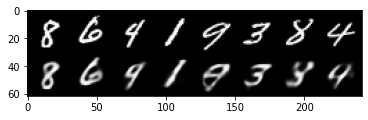

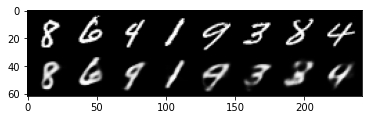

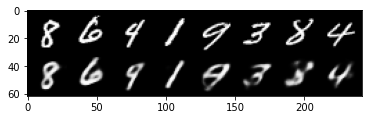

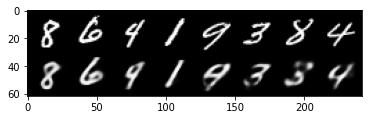

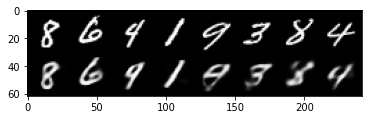

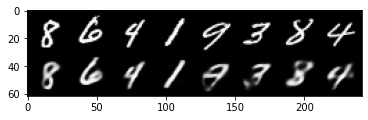

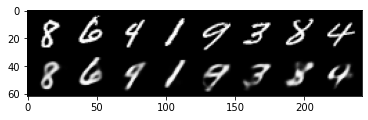

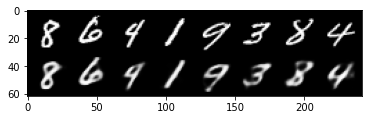

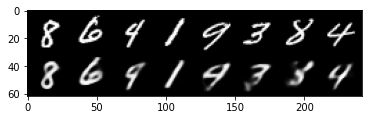

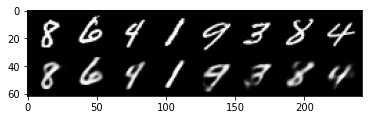

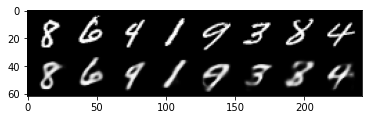

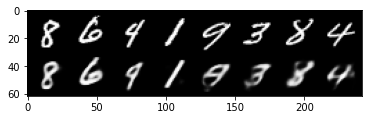

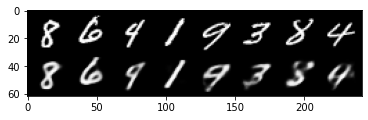

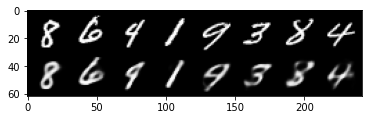

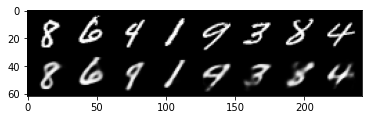

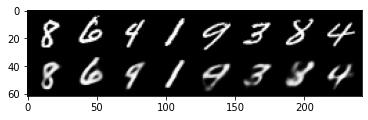

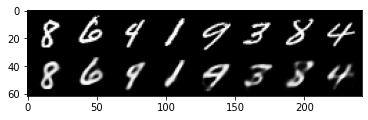

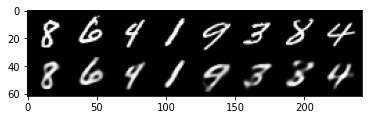

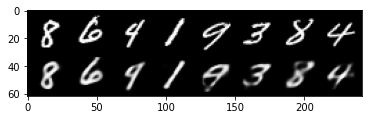

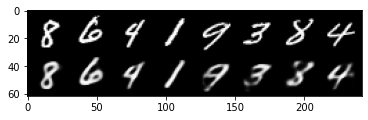

In [37]:
for i in range(epochs):
    img = mpimg.imread("./outputs/output" + str(i) + ".png")
    imgplot = plt.imshow(img)
    plt.show()

# Clean-up the repository
<hr style="border:2px solid black"> </hr>

In [3]:
try:
    shutil.rmtree("./input")
except:
    pass

try:
    shutil.rmtree("./outputs")
except:
    pass

# References
<hr style="border:2px solid black"> </hr>


- https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
- https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed
- https://github.com/williamFalcon/pytorch-lightning-vae  
- https://colab.research.google.com/drive/1_yGmk8ahWhDs23U4mpplBFa-39fsEJoT?usp=sharing#scrollTo=EYDKIsTtk3hJ
- https://github.com/ethen8181/machine-learning/blob/master/model_selection/kl_divergence.ipynb 

